# Demographics

### This analysis compares the demographic characteristics of the intervention and waitlist control groups. Specifically, we compare the means of various demographic variables between the two groups using t-tests, as well as examining the distribution of categorical variables using chi-squared tests. The demographic variables include age, ethnicity, employment status, education level, and previous app use.

### This analysis provides insight into any potential differences between the two groups that may need to be accounted for in subsequent analyses. 

In [319]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings("ignore")
dir = '/Users/garvert/Documents/Alena/RCT/rct-data/rct-2023-03/'

df = pd.read_csv(dir + 'preprocessed_data/merged.csv', delimiter=',', error_bad_lines=False)

print('Age:')
t, p = stats.ttest_ind(df['age'][df['group'] == 'Waitlist'], df['age'][df['group'] == 'Intervention'])
intervention_mean = df['age'][df['group'] == 'Intervention'].mean()
intervention_std = df['age'][df['group'] == 'Intervention'].std()
waitlist_mean = df['age'][df['group'] == 'Waitlist'].mean()
waitlist_std = df['age'][df['group'] == 'Waitlist'].std()
print('Intervention mean, std: {:.2f}, {:.2f}'.format(intervention_mean, intervention_std))
print('Waitlist mean, std: {:.2f}, {:.2f}'.format(waitlist_mean, waitlist_std))
print('t: {:.2f}, p: {:.2f}\n'.format(t, p))

print('\nSex:')
observations = pd.crosstab(index=df["sex"], columns=df["group"],margins=False)
chi2, p, dof, ex = chi2_contingency(observations)
print(observations)
print("chi2 = ", chi2)
print("p = ", p)

print('\nEthnicity:')
observations = pd.crosstab(index=df["eth_original"], columns=df["group"],margins=False)
chi2, p, dof, ex = chi2_contingency(observations)
print(observations)
print("chi2 = ", chi2)
print("p = ", p)

print('\nEmployment:')
observations = pd.crosstab(index=df["employ_original"], columns=df["group"],margins=False)
chi2, p, dof, ex = chi2_contingency(observations)
print(observations)
print("chi2 = ", chi2)
print("p = ", p)

print('\nEducation:')
observations = pd.crosstab(index=df["edu_original"], columns=df["group"],margins=False)
chi2, p, dof, ex = chi2_contingency(observations)
print(observations)
print("chi2 = ", chi2)
print("p = ", p)

print('\nPrevious app use:')
observations = pd.crosstab(index=df["apps_original"], columns=df["group"],margins=False)
chi2, p, dof, ex = chi2_contingency(observations)
print(observations)
print("chi2 = ", chi2)
print("p = ", p)

print('\nPrevious therapy experience experience:')
observations = pd.crosstab(index=df["thpy_original"], columns=df["group"],margins=False)
chi2, p, dof, ex = chi2_contingency(observations)
print(observations)
print("chi2 = ", chi2)
print("p = ", p)

print('\nSPIN at baseline:')
t, p = stats.ttest_ind(df['spintot_w0'][df['group'] == 'Waitlist'], df['spintot_w0'][df['group'] == 'Intervention'])
intervention_mean = df['spintot_w0'][df['group'] == 'Intervention'].mean()
intervention_std = df['spintot_w0'][df['group'] == 'Intervention'].std()
waitlist_mean = df['spintot_w0'][df['group'] == 'Waitlist'].mean()
waitlist_std = df['spintot_w0'][df['group'] == 'Waitlist'].std()
print('Intervention mean, std: {:.2f}, {:.2f}'.format(intervention_mean, intervention_std))
print('Waitlist mean, std: {:.2f}, {:.2f}'.format(waitlist_mean, waitlist_std))
print('t: {:.2f}, p: {:.2f}\n'.format(t, p))


plt.style.use('default')
plt.rcParams.update({'font.family':'sans-serif'})
plt.rcParams.update({'font.sans-serif':'Arial'})
plt.rcParams.update({'font.size': 8})

Age:
Intervention mean, std: 39.29, 10.65
Waitlist mean, std: 38.15, 10.84
t: nan, p: nan


Sex:
group   Intervention  Waitlist
sex                           
Female            73        80
Male              46        45
chi2 =  0.08780622837370268
p =  0.7669848297742401

Ethnicity:
group                         Intervention  Waitlist
eth_original                                        
Any other ethnic group                   3         2
Asian/Asian British                      6         8
Black/Black British                      6         1
Mixed/Multiple ethnic groups             6         3
White/White British                    103       111
chi2 =  5.35227853912744
p =  0.2530226725071051

Employment:
group                                               Intervention  Waitlist
employ_original                                                           
Retired                                                        2         2
Student                                                  

# Adverse events

### The code extracts information on adverse events reported by the intervention and the waitlist control group and exports it to CSV files for further analysis. The code loops through CSV files in a directory for each group and week, and counts the number of participants who reported any new effects in the past week. The data is then exported to a CSV file. It is important to note that the questions that were asked are different between the groups, results can therefore not be direclty compared!
### Intervention group: 'Have you experienced any negative effects from using the Alena app?': 'advapp_original_w'+str(i)
### Waitlist group: 'Have you experienced any negative effects from taking part in this study? ': 'advall_original_w'+str(i),

In [320]:
# Create two separate dataframes for the intervention and waitlist groups. The two groups were asked different questions, results can therefore not be direclty compared!
# Intervention group: 'Have you experienced any negative effects from using the Alena app?': 'advapp_original_w'+str(i)
# Waitlist group: 'Have you experienced any negative effects from taking part in this study? ': 'advall_original_w'+str(i),

# create a dataframe for the intervention group                            
adv_df = pd.DataFrame(columns=['group','pid', 'week','response','severity','description'])
print('\nIntervention group:')

for week in range(1,11):
    col_name = 'advapp_original_w' + str(week)
    if col_name in df.columns:  # Check if column exists
        count = 0

        # count the number of "Yes" or "I'm not sure" in the column "Have you experienced any new, serious negative health effects in the past week?"
        count = 0
        for index, row in df.iterrows():
            if row[col_name] in ['Yes', "I'm not sure"]:
                count += 1
                pid = row['pid']
                descr = row['advapp_qual_w' + str(week)]
                severity = row['advapp_sev_w' + str(week)]
                adv_df = adv_df.append({'group': row['group'], 'pid': pid, 'week': week, 'response': row[col_name], 'severity': severity,'description': descr}, ignore_index=True)
        print('Week', week, ':', count)

adv_df.drop_duplicates(inplace=True)
adv_df.to_csv('adverse_outcomes_intervention.csv')

print('\nWaitlist group:')
# create a dataframe for the waitlist group
adv_df = pd.DataFrame(columns=['group','pid', 'week','response','severity','description'])
for week in range(1,11):
    col_name = 'advall_original_w' + str(week)
    if col_name in df.columns:  # Check if column exists
        count = 0

        # count the number of "Yes" or "I'm not sure" in the column "Have you experienced any new, serious negative health effects in the past week?"
        count = 0
        for index, row in df.iterrows():
            if row[col_name] in ['Yes', "I'm not sure"]:
                count += 1
                pid = row['pid']
                descr = row['advall_original_w' + str(week)]
                severity = row['advall_original_w' + str(week)]
                adv_df = adv_df.append({'group': row['group'], 'pid': pid, 'week': week, 'response': row[col_name], 'severity': severity,'description': descr}, ignore_index=True)
        print('Week', week, ':', count)

adv_df.drop_duplicates(inplace=True)
adv_df.to_csv('adverse_outcomes_waitlist.csv')

# count the total number of entries for each group
group_counts = adv_df['group'].value_counts()

# count the number of unique pids in each group
unique_pids = adv_df.groupby('group')['pid'].nunique()





Intervention group:
Week 1 : 11
Week 2 : 5

Waitlist group:
Week 2 : 1


# Questionnaire completion rates by week

### The code calculates the percentage of missing values at each time point for each group and performs a chi-square test to determine if there is a significant difference in the missing values between groups.




########################

Week 0
group       Intervention  Waitlist
spintot_w0                        
False                124       125
chi2 = 0.0
p = 1.0



########################

Week 1
group       Intervention  Waitlist
spintot_w1                        
False                106       123
True                  18         2
chi2 = 12.364087283420202
p = 0.0004376714753904672



########################

Week 2
group       Intervention  Waitlist
spintot_w2                        
False                109       125
True                  15         0
chi2 = 14.024415260545906
p = 0.0001804522787211726


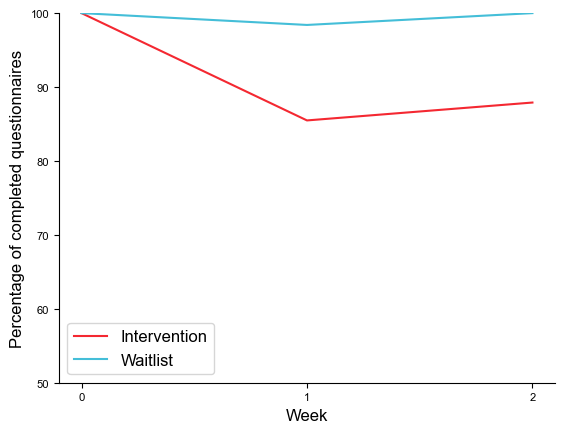

In [321]:
import pandas as pd
from scipy.stats import ttest_ind, chi2_contingency

# Select the columns of interest
df = pd.read_csv(dir + 'preprocessed_data/merged.csv', delimiter=',', error_bad_lines=False)

# Define a function to compute the percentage of missing values
def nonmissing_percentage(column):
    return 100 - (column.isna().sum() / len(column) * 100)


# Test for statistical significance using a chi-square test
p_values = []
columns_of_interest = []

# Iterate over the weeks and perform the calculations
for week in range(0, 10):  # List of weeks to check
    column_name = "spintot_w" + str(week)
    
    if column_name in df.columns:
        columns_of_interest.append(column_name)
        print('\n\n\n########################\n\nWeek', week)
        missing_data = df[column_name].isnull()
        observations = pd.crosstab(index=missing_data, columns=df["group"], margins=False)
        chi2, p, dof, ex = chi2_contingency(observations)
        print(observations)
        print("chi2 =", chi2)
        print("p =", p)
        p_values.append(p)
        
# Calculate percentage of complete data per group
group_percentage = df.groupby('group')[columns_of_interest].apply(lambda x: (~x.isnull()).mean()) * 100

# Extract the weeks from column names
weeks = [int(col.split('_')[1][1:]) for col in columns_of_interest]

# Create a line plot# Define line colors
line_colors = ["#f42831", "#44bed8"]

# Create a line plot
fig, ax = plt.subplots()
for i, group in enumerate(group_percentage.index):
    ax.plot(weeks, group_percentage.loc[group], label=group, color=line_colors[i])


ax.set_xlabel('Week', fontsize=12)
ax.set_ylabel('Percentage of completed questionnaires', fontsize=12)
ax.set_ylim(50, 100)  # Set y-axis limits
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(weeks, weeks)
# Move legend to bottom left corner
ax.legend(loc='lower left', bbox_to_anchor=(0, 0), fontsize=12)
plt.show()

# Acceptability

### This analysis examines the acceptability of the intervention. The first section of the code compares the reported completion rates of the intervention group at different time points. The second section of the code plots a histogram showing the number of completed modules by participants at the end of the four-week intervention.

### The remaining sections of the code examine the satisfaction, helpfulness, ease of use, recommendation, and completion rates of the intervention program. For each of these variables, the code creates a plot that displays the percentage of responders who fall into different response categories at different time points. The plots are saved to an output file called 'acceptability.eps'.

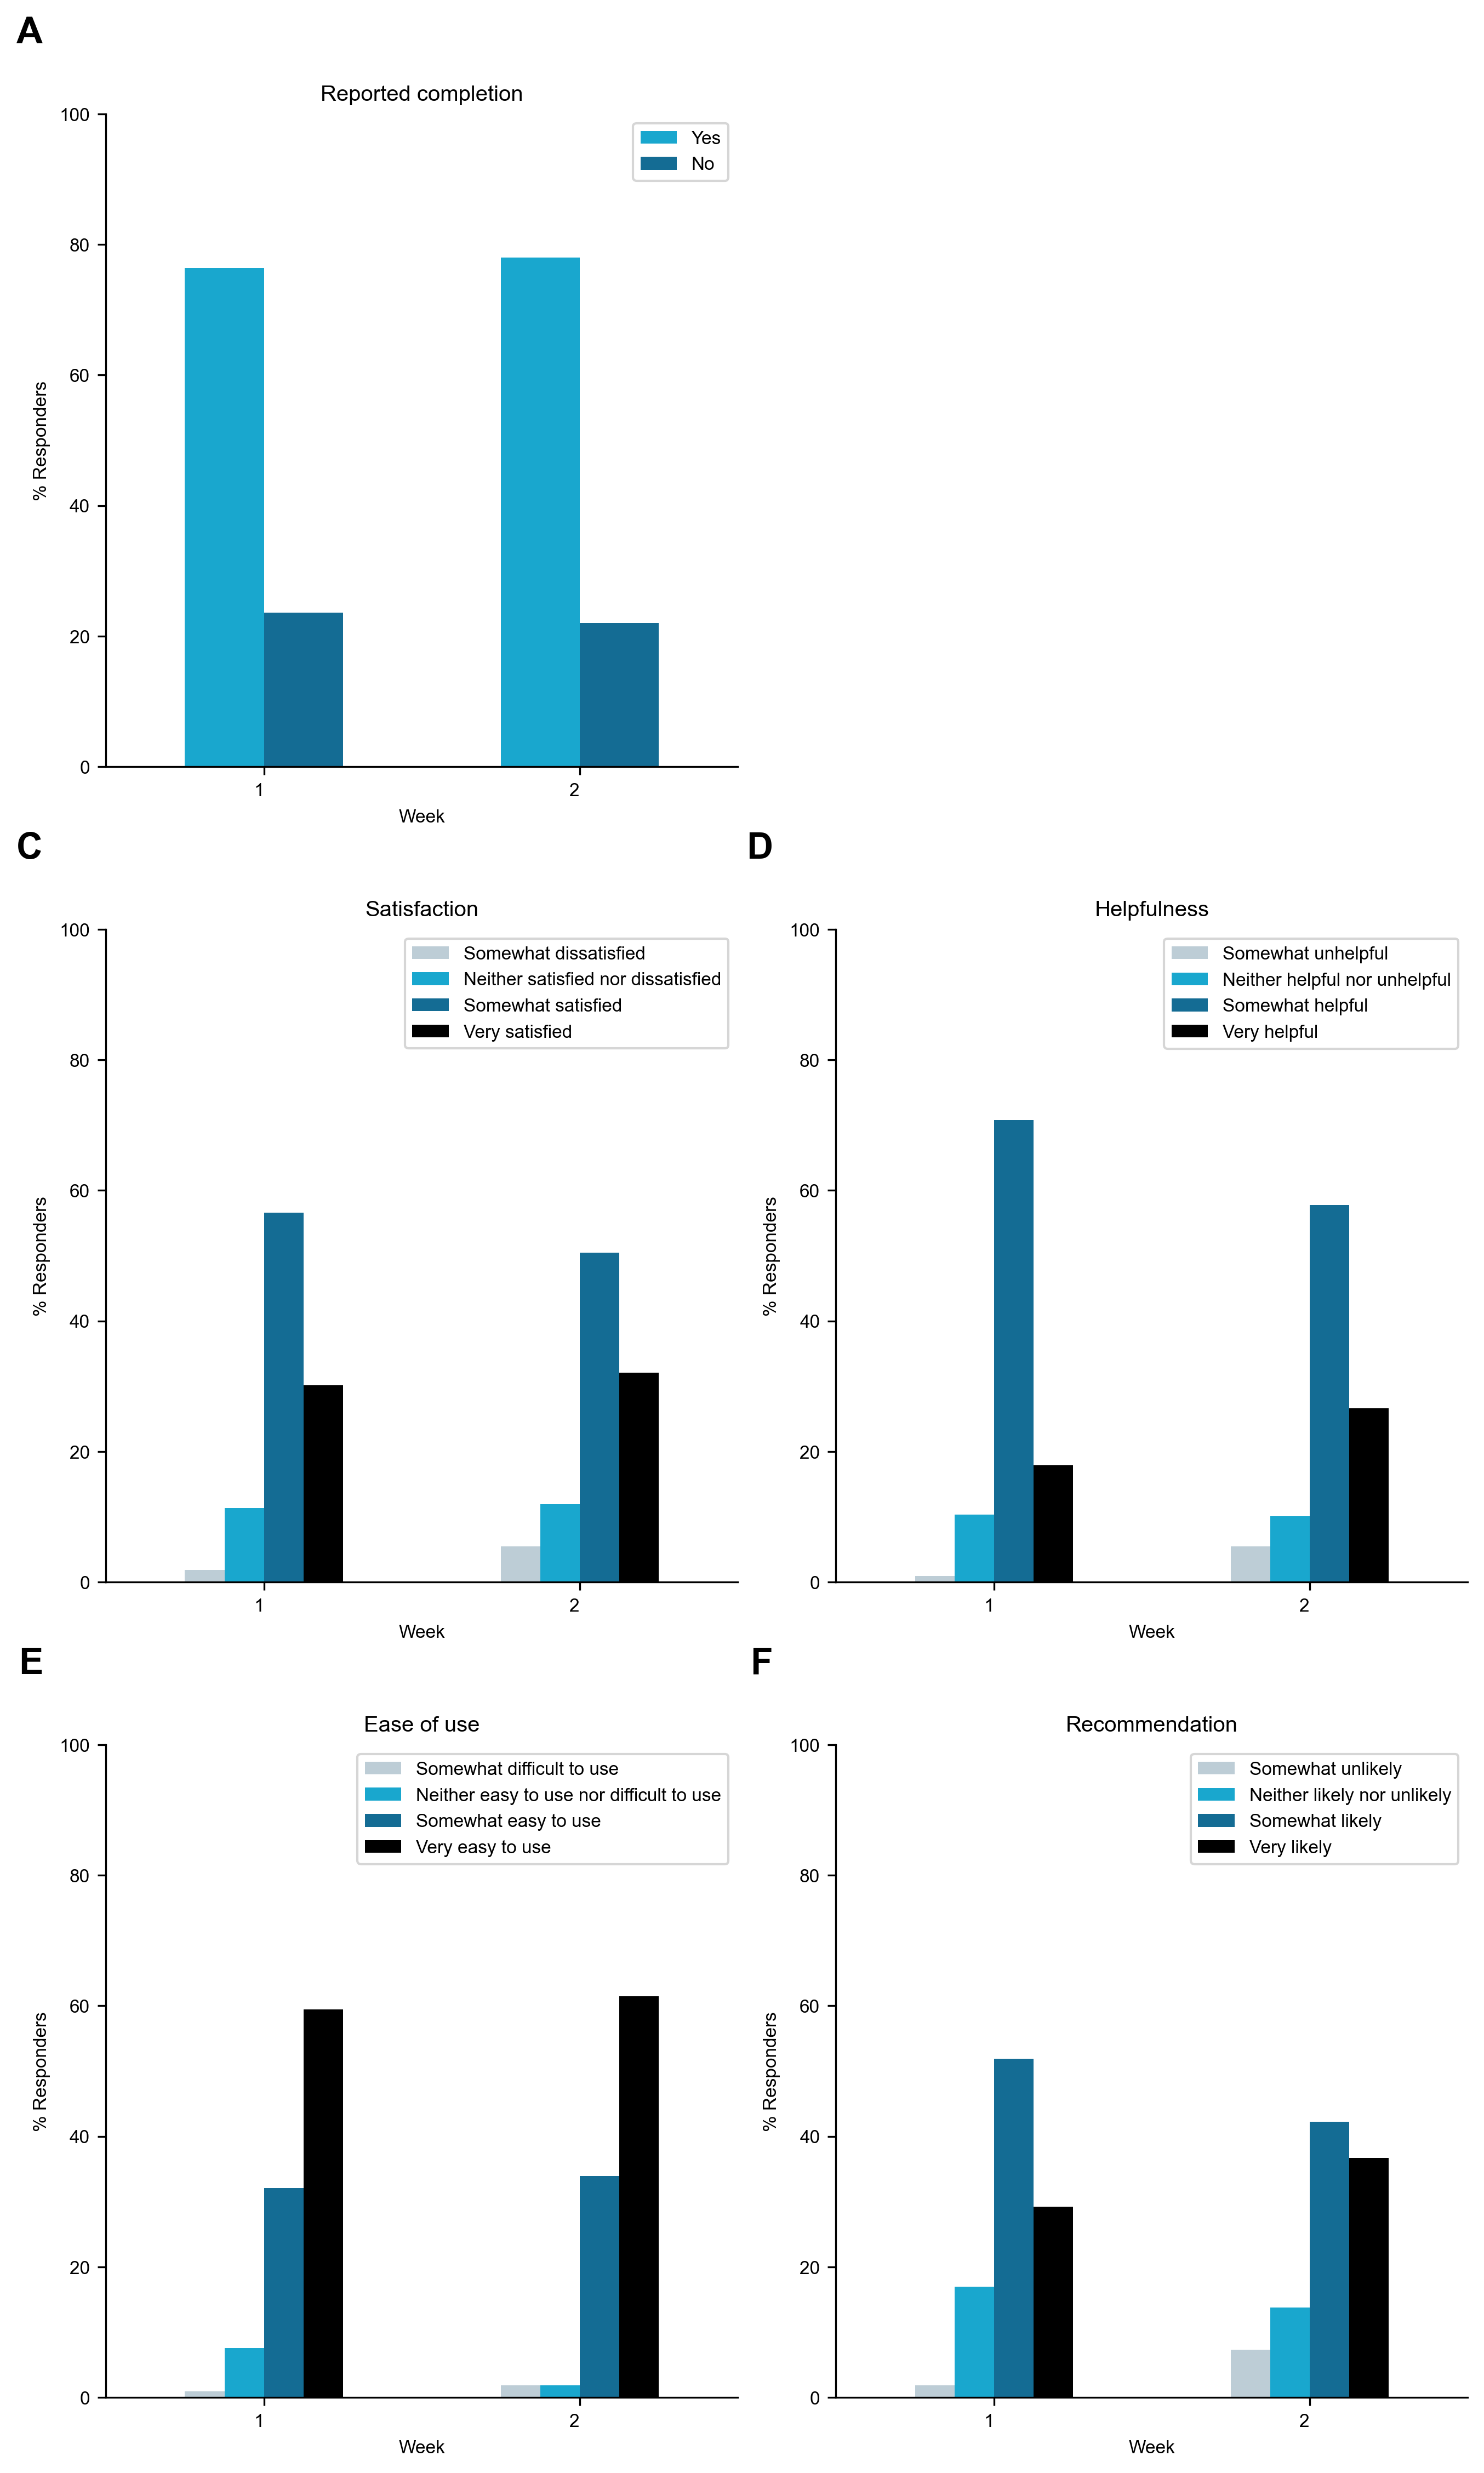

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [322]:
# Acceptability data
import statsmodels.api as sm
import statsmodels.formula.api as smf

df_int = df[df['group'] == 'Intervention']

title = 'Reported completion'
variables = ['end_original_w']
order = {'end_original_w': ['Yes','No']}

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,15), dpi = dpi)

vix = 'end_original_w'
satis = df_int[[vix+"1",vix+"2"]]
satis = pd.melt(satis, value_vars = [vix+"1",vix+"2"])
freq = pd.crosstab(satis.variable, satis.value, normalize='index')*100
freq = freq[order[vix]]

ax = fig.add_subplot(3,2,1)
ax.text(-0.1, 1.15, 'A', transform=ax.transAxes,
  fontsize=16, fontweight='bold', va='top', ha='right')

g = freq.plot(kind='bar', color=["#19A7CE","#146C94", "#000000"], ax = ax)
g.set(xticklabels = ['1','2'], ylim = (0,100), xlabel = 'Week', ylabel = '% Responders', title = title)
plt.xticks(rotation=360, ha='right')
ax.spines[['right', 'top']].set_visible(False)
ax.legend(loc=0, title='')

# satis = df_int[['M0M1complete','M2complete',	'M3complete',	'M4complete']]
# df = satis.mean(axis = 1)*4

# ax = fig.add_subplot(3,2,2)
# df.plot.hist(bins = [-0.3,0.3,0.7,1.3,1.7,2.3,2.7,3.3,3.7,4.3], color = ["#19A7CE"])
# ax.set_xlabel('Completed modules')
# ax.set_ylabel('Number of participants')
# ax.set_title('Objectively completed modules\nat the end of four weeks')
# ax.spines[['right', 'top']].set_visible(False)
# ax.text(-0.1, 1.15, 'B', transform=ax.transAxes,
#   fontsize=16, fontweight='bold', va='top', ha='right')



title = ['Satisfaction', 'Helpfulness', 'Ease of use', 'Recommendation', 'Completion']
variables = ['satis_original_w', 'help_original_w','easy_original_w','recc_original_w', 'end_original_w']

order = {'satis_original_w': ['Somewhat dissatisfied','Neither satisfied nor dissatisfied','Somewhat satisfied','Very satisfied'],
'help_original_w': ['Somewhat unhelpful','Neither helpful nor unhelpful','Somewhat helpful','Very helpful'],
'recc_original_w': ['Somewhat unlikely','Neither likely nor unlikely','Somewhat likely','Very likely'],
'easy_original_w': ['Somewhat difficult to use','Neither easy to use nor difficult to use','Somewhat easy to use','Very easy to use'],
'end_original_w': ['Yes','No']}

import matplotlib.pyplot as plt

for i, label in enumerate(('C', 'D', 'E', 'F')):
    vix = variables[i]
    satis = df_int[[vix+"1",vix+"2"]]
    satis = pd.melt(satis, value_vars = [vix+"1",vix+"2"])
    freq = pd.crosstab(satis.variable, satis.value, normalize='index')*100
    freq = freq[order[vix]]

    ax = fig.add_subplot(3,2,i+3)
    ax.text(-0.1, 1.15, label, transform=ax.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

    g = freq.plot(kind='bar', color=["#BDCDD6", "#19A7CE","#146C94", "#000000"], ax = ax)
    g.set(xticklabels = ['1','2'], ylim = (0,100), xlabel = 'Week', ylabel = '% Responders', title = title[i])
    plt.xticks(rotation=360, ha='right')
    ax.spines[['right', 'top']].set_visible(False)
    ax.legend(loc=0, title='')

plt.tight_layout()
    
plt.show()
fig.savefig('figures/acceptability.eps', transparent=False)


# Efficacy

### This code visualizes the results of the RCT in terms of efficacy. The code first performs an intention-to-treat analysis on SPIN and WSAS scores, which includes all randomized participants regardless of adherence to the intervention. The lines represent mean and standard errors. The intention-to-treat analysis is followed by a per-protocol analysis, which includes only participants who completed the intervention. The figure is then saved as an eps file.

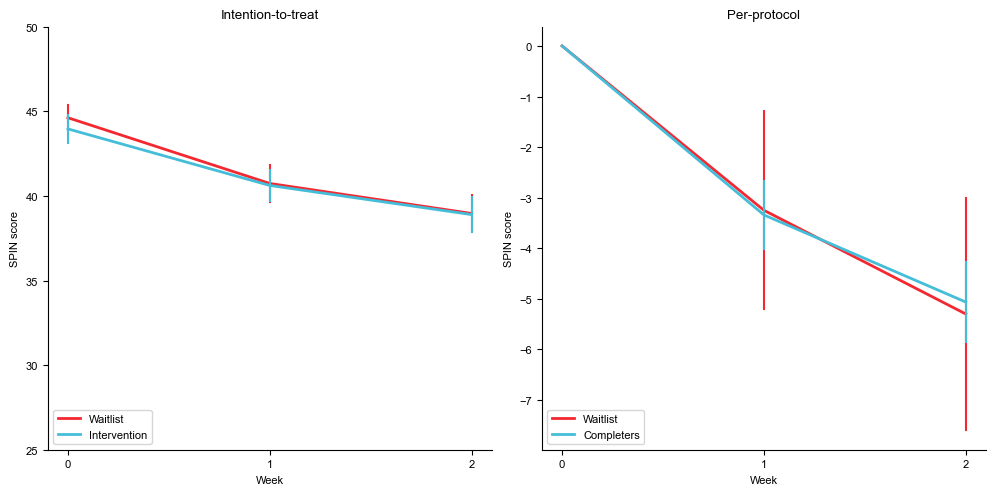

In [328]:

#Intention-to-treat analysis
df = pd.read_csv(dir + 'preprocessed_data/merged.csv', delimiter=',', error_bad_lines=False)

columns_of_interest = ['group']

# Iterate over the weeks and perform the calculations
for week in range(0, 10):  # List of weeks to check
    column_name = "spintot_w" + str(week)
    
    if column_name in df.columns:
        columns_of_interest.append(column_name)
        
spin = df[columns_of_interest]
spin_melted = spin.melt(id_vars = 'group', var_name="timepoint", value_name="SPIN score")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
g = sns.lineplot(data=spin_melted, x = 'timepoint', y = 'SPIN score', hue = 'group', 
                err_style="bars", errorbar=("se"), palette=["#f42831", "#44bed8"], linewidth=2, ax = ax1)
ax1.legend(labels=["Waitlist","Intervention"], loc = 3)
g.set(xticklabels = ['0','1','2','3','4','5',"6",'7','8'], ylim = (25,50), xlabel = 'Week', title='Intention-to-treat')
ax1.spines[['right', 'top']].set_visible(False)


# Per-protocol analysis
df = df.drop(df[(df['beliefs_not_completed'] == True) | (df['attention_not_completed'] == True)].index)
spin = df[columns_of_interest]
spin.iloc[:, 1:] = spin.iloc[:, 1:].sub(spin["spintot_w0"], axis=0)
spin_melted = spin.melt(id_vars = 'group', var_name="timepoint", value_name="SPIN score")

g = sns.lineplot(data=spin_melted, x = 'timepoint', y = 'SPIN score', hue = 'group', 
                err_style="bars", errorbar=("se"), palette=["#f42831", "#44bed8"], linewidth=2, ax = ax2)
ax2.legend(labels=["Waitlist","Completers"], loc = 3)
ax2.spines[['right', 'top']].set_visible(False)
g.set(xticklabels = ['0','1','2','3','4','5',"6",'7','8'], xlabel = 'Week', title='Per-protocol')



plt.tight_layout()
plt.show()


# Change in SPIN in an intention-to-treat sample by week

### Regression analyses are performed on the data separately for each time point, represented by variables 'spintot_w1', 'spintot_w2', 'spintot_w3', 'spintot_w4', and 'spintot_w6'. Each iteration of the loop predicts SPIN at the current time point, and includes 'group', 'spintot_0' and 'age' as regressors. The analysis is done under an intention-to-treat framework, which means that all participants are analyzed according to the group to which they were randomized, regardless of whether or not they received the intervention.


In [332]:
# Regression analyses, intention-to-treat, SPIN
import statsmodels.api as sm

df = pd.read_csv(dir + 'preprocessed_data/merged.csv', delimiter=',', error_bad_lines=False)


# Iterate over the weeks and perform the calculations
for week in range(1, 10):  # List of weeks to check
    column_name = "spintot_w" + str(week)
    
    if column_name in df.columns:
        columns_of_interest.append(column_name)

        d = df[['group','spintot_w0','age',column_name]]

        just_dummies = pd.get_dummies(d['group'])
        step1 = pd.concat([d,just_dummies], axis = 1)

        result = sm.OLS(step1[column_name], sm.add_constant(step1[['spintot_w0', 'Intervention','age']]), missing='drop').fit()
        print('\n\n\n########################\n\nWeek '+ column_name[-1])
        print (result.summary())





########################

Week 1
                            OLS Regression Results                            
Dep. Variable:             spintot_w1   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     58.04
Date:                Thu, 20 Apr 2023   Prob (F-statistic):           9.06e-28
Time:                        15:38:59   Log-Likelihood:                -792.68
No. Observations:                 227   AIC:                             1593.
Df Residuals:                     223   BIC:                             1607.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const       

# Change in SPIN in a per-protocol sample by week

### The code performs regression analyses for per-protocol analysis on the SPIN data, i.e only participants in the intervention group are included who completed all therapy modules. Regression analyses are performed on the data separately for each time point, represented by variables 'spintot_w1', 'spintot_w2', 'spintot_w3', 'spintot_w4', and 'spintot_w6'. Each iteration of the loop predicts SPIN at the current time point, and includes 'group', 'spintot_0' and 'age' as regressors. 

In [333]:
# Regression analyses, per-protocol, SPIN
import statsmodels.api as sm
df = pd.read_csv(dir + 'preprocessed_data/merged.csv', delimiter=',', error_bad_lines=False)
df = df.drop(df[(df['beliefs_not_completed'] == True) | (df['attention_not_completed'] == True)].index)


# Iterate over the weeks and perform the calculations
for week in range(1, 10):  # List of weeks to check
    column_name = "spintot_w" + str(week)
    
    if column_name in df.columns:
        columns_of_interest.append(column_name)

        d = df[['group','spintot_w0','age',column_name]]

        just_dummies = pd.get_dummies(d['group'])
        step1 = pd.concat([d,just_dummies], axis = 1)

        result = sm.OLS(step1[column_name], sm.add_constant(step1[['spintot_w0', 'Intervention','age']]), missing='drop').fit()
        print('\n\n\n########################\n\nWeek '+ column_name[-1])
        print (result.summary())






########################

Week 1
                            OLS Regression Results                            
Dep. Variable:             spintot_w1   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     45.98
Date:                Thu, 20 Apr 2023   Prob (F-statistic):           1.15e-20
Time:                        15:39:47   Log-Likelihood:                -485.29
No. Observations:                 142   AIC:                             978.6
Df Residuals:                     138   BIC:                             990.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const       

# Reliable change in SPIN in intention-to-treat sample at week 4

### This code computes the change in SPIN for each participant as the difference between their baseline score (spintot_0) and their score at week 4 (spintot_w4). It then creates a contingency table, with one column for each treatment group (Intervention and Control) and one row indicating whether or not the improvement was greater than or equal to 10 points.

### It then computes the chi-squared test statistic and associated p-value for the contingency table. The observed contingency table, chi-squared test statistic, and p-value are printed to the console.

### Finally, the code creates a second contingency table with the same row variable but normalized across the columns.

In [ ]:
df = pd.read_csv(dir + 'preprocessed_data/merged.csv', delimiter=',', error_bad_lines=False)
df['reliable_improvement'] = (df['spintot_w0'] - df['spintot_w4']) 

observations = pd.crosstab(index=df["reliable_improvement"]>=10, columns=df["group"],margins=False)
chi2, p, dof, ex = chi2_contingency(observations)
print("\n### Absolute numbers \n")
print(observations)
print("\nchi2 = ", chi2)
print("p = ", p)

print("\n### Relative numbers\n")
rel_observations = pd.crosstab(index=df["reliable_improvement"]>=10, columns=df["group"],margins=False, normalize='columns')
print(rel_observations)

# Reliable change in SPIN in per-protocol sample at week 4

### This code computes the change in SPIN for each participant as the difference between their baseline score (spintot_0) and their score at week 4 (spintot_w4). It then creates a contingency table, with one column for each treatment group (Intervention and Control) and one row indicating whether or not the improvement was greater than or equal to 10 points. The intervention group only includes participants who completed all therapy modules

### It then computes the chi-squared test statistic and associated p-value for the contingency table. The observed contingency table, chi-squared test statistic, and p-value are printed to the console.

### Finally, the code creates a second contingency table with the same row variable but normalized across the columns.

In [ ]:
df = pd.read_csv(dir + 'preprocessed_data/merged.csv', delimiter=',', error_bad_lines=False)
df = df.drop(df[(df['beliefs_not_completed'] == True) | (df['attention_not_completed'] == True)].index)

df['reliable_improvement'] = (df['spintot_w0'] - df['spintot_w4']) 

observations = pd.crosstab(index=df["reliable_improvement"]>=10, columns=df["group"],margins=False)
chi2, p, dof, ex = chi2_contingency(observations)
print("\n### Absolute numbers \n")
print(observations)
print("\nchi2 = ", chi2)
print("p = ", p)

rel_observations = pd.crosstab(index=df["reliable_improvement"]>=10, columns=df["group"],margins=False, normalize='columns')
print("\n### Relative numbers\n")
print(rel_observations)

# Exploratory analyses examining the effect of specific interventions on SPIN



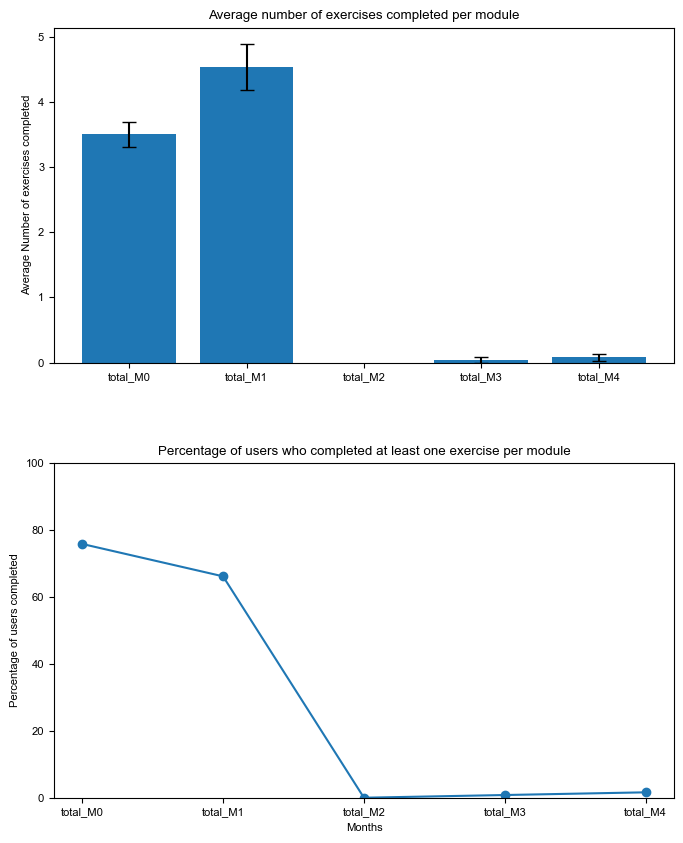

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a DataFrame 'df' with columns 'group', 'total_M0', 'total_M1', 'total_M2', 'total_M3', 'total_M4'

# Filter rows where 'group' is equal to "Intervention"
intervention_adherence = df[df['group'] == "Intervention"]

# Calculate the average and SEM of the columns for Intervention group
average_values = intervention_adherence[['total_M0', 'total_M1', 'total_M2', 'total_M3', 'total_M4']].mean()
sem_values = intervention_adherence[['total_M0', 'total_M1', 'total_M2', 'total_M3', 'total_M4']].sem()

# Calculate the percentage of users who completed at least one exercise at each time point
completed_percentages = (intervention_adherence[['total_M0', 'total_M1', 'total_M2', 'total_M3', 'total_M4']] > 0).mean() * 100

# Create a figure with two subplots: one for average adherence with SEM, and one for completed percentages
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot average adherence with SEM on ax1
ax1.bar(average_values.index, average_values.values, yerr=sem_values.values, capsize=5)
ax1.set_ylabel('Average Number of exercises completed')
ax1.set_title('Average number of exercises completed per module')
ax1.set_ylim(0)

# Plot completed percentages on ax2
ax2.plot(completed_percentages.index, completed_percentages.values, marker='o')
ax2.set_xlabel('Months')
ax2.set_ylabel('Percentage of users completed')
ax2.set_title('Percentage of users who completed at least one exercise per module')
ax2.set_ylim(0, 100)

# Customize the appearance of the plots
plt.subplots_adjust(hspace=0.3)  # Adjust the vertical spacing between subplots
ax2.set_xticks(completed_percentages.index)  # Set x-ticks on ax2 to match x-ticks on ax1

# Show the plot
plt.show()


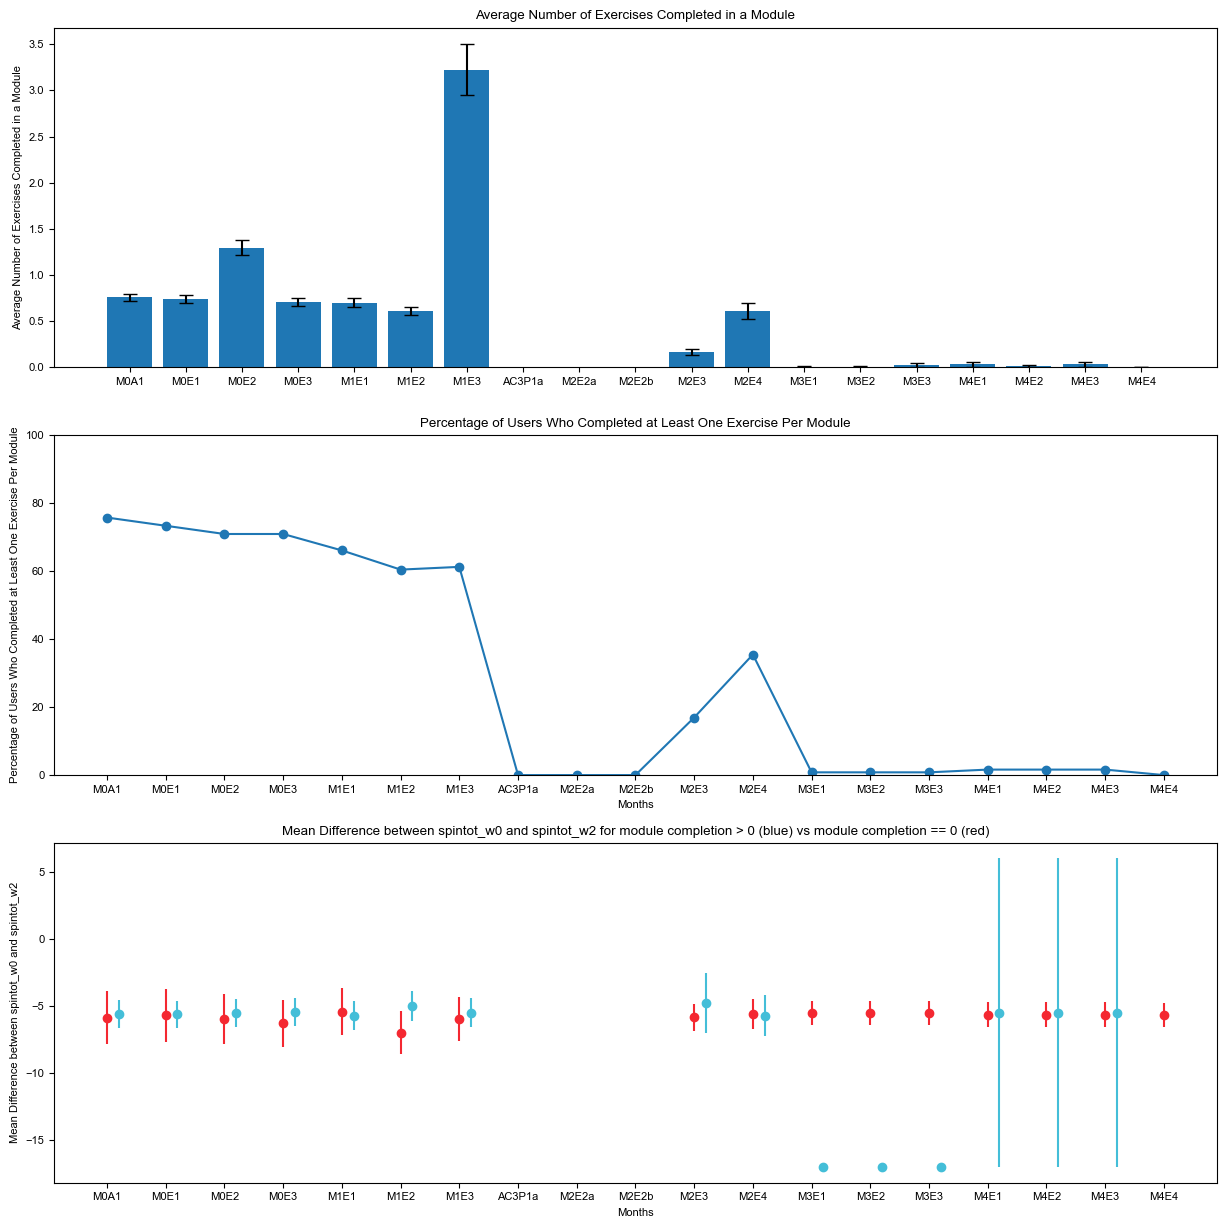

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a DataFrame 'df' with columns 'group', 'total_M0', 'total_M1', 'total_M2', 'total_M3', 'total_M4',
# 'M0A1', 'M0E1', 'M0E2', 'M0E3', 'M1E1', 'M1E2', 'M1E3', 'AC3P1a', 'M2E2a', 'M2E2b', 'M2E3', 'M2E4', 'M3E1', 'M3E2', 'M3E3', 'M4E1', 'M4E2', 'M4E3', 'M4E4'

# Filter rows where 'group' is equal to "Intervention"
intervention_adherence = df[df['group'] == "Intervention"]

# Columns to calculate average and SEM
columns_to_average = ['M0A1', 'M0E1', 'M0E2', 'M0E3',
                     'M1E1', 'M1E2', 'M1E3', 'AC3P1a', 'M2E2a', 'M2E2b', 'M2E3', 'M2E4', 'M3E1', 'M3E2', 'M3E3',
                     'M4E1', 'M4E2', 'M4E3', 'M4E4']

# Calculate the average and SEM of the columns for Intervention group
average_values = intervention_adherence[columns_to_average].mean()
sem_values = intervention_adherence[columns_to_average].sem()

# Calculate the percentage of users who completed at least one exercise at each time point
completed_percentages = (intervention_adherence[columns_to_average] > 0).mean() * 100

# Create a figure with three subplots: one for average adherence with SEM, one for completed percentages, and one for the difference between 'spintot_w0' and 'spintot_w2'
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

# Plot average adherence with SEM on ax1
ax1.bar(average_values.index, average_values.values, yerr=sem_values.values, capsize=5)
ax1.set_ylabel('Average Number of Exercises Completed in a Module')
ax1.set_title('Average Number of Exercises Completed in a Module')
ax1.set_ylim(0)

# Plot completed percentages on ax2
ax2.plot(completed_percentages.index, completed_percentages.values, marker='o')
ax2.set_xlabel('Months')
ax2.set_ylabel('Percentage of Users Who Completed at Least One Exercise Per Module')
ax2.set_title('Percentage of Users Who Completed at Least One Exercise Per Module')
ax2.set_ylim(0, 100)

intervention_adherence['difference_values'] = intervention_adherence['spintot_w0'] - intervention_adherence['spintot_w2']
completed_percentages = (intervention_adherence[columns_to_average] > 0).mean() * 100

# Calculate the difference between 'spintot_w0' and 'spintot_w2'
difference_values = intervention_adherence['spintot_w2'] - intervention_adherence['spintot_w0']

# Plot difference between 'spintot_w0' and 'spintot_w2' on ax2
# Loop through columns_to_average
for i, column in enumerate(columns_to_average):
    # Calculate the mean of difference_values for users with intervention_adherence[column] > 0
    mean_difference_positive = difference_values[intervention_adherence.index][intervention_adherence[column] > 0].mean()
    # Calculate the mean of difference_values for users with intervention_adherence[column] == 0
    mean_difference_zero = difference_values[intervention_adherence.index][intervention_adherence[column] == 0].mean()

    # Calculate standard deviation of difference_values for users with intervention_adherence[column] > 0
    std_difference_positive = difference_values[intervention_adherence.index][intervention_adherence[column] > 0].sem()
    # Calculate standard deviation of difference_values for users with intervention_adherence[column] == 0
    std_difference_zero = difference_values[intervention_adherence.index][intervention_adherence[column] == 0].sem()

    ax3.errorbar(i, mean_difference_zero, yerr=std_difference_zero, marker='o', label=f'{column} == 0', color="#f42831", mec="#f42831")
    ax3.errorbar(i+0.2, mean_difference_positive, yerr=std_difference_positive, marker='o', label=f'{column} > 0', color="#44bed8", mec="#44bed8")
    
    ax3.set_xlabel('Months')
    ax3.set_ylabel('Mean Difference between spintot_w0 and spintot_w2')
    ax3.set_title(f'Mean Difference between spintot_w0 and spintot_w2 for module completion > 0 (blue) vs module completion == 0 (red)')
    ax3.set_xticks(range(0,len(columns_to_average))) # Set xticks to match index of intervention_adherence DataFrame
    ax3.set_xticklabels(columns_to_average) # Set xtick labels to 'group' values with rotation

# Customize the appearance of the plots


Text(0, 0.5, 'Change in SPIN')

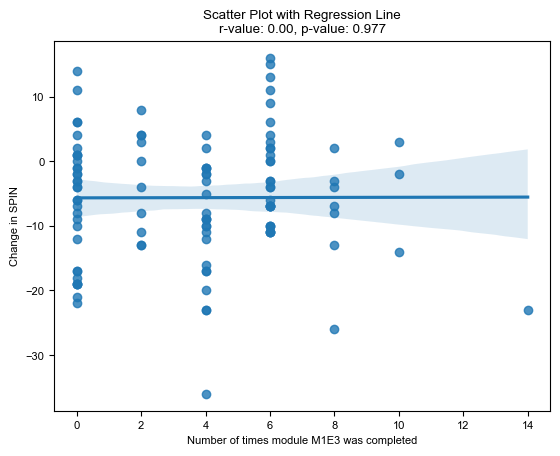

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Assuming you have a DataFrame 'df' with columns 'group', 'total_M0', 'total_M1', 'total_M2', 'total_M3', 'total_M4',
# 'M0A1', 'M0E1', 'M0E2', 'M0E3', 'M1E1', 'M1E2', 'M1E3', 'AC3P1a', 'M2E2a', 'M2E2b', 'M2E3', 'M2E4', 'M3E1', 'M3E2', 'M3E3', 'M4E1', 'M4E2', 'M4E3', 'M4E4'

# Filter rows where 'group' is equal to "Intervention"
intervention_adherence = df[df['group'] == "Intervention"]

# Columns to calculate average and SEM
columns_to_average = ['M1E3']

# Create a figure with three subplots: one for average adherence with SEM, one for completed percentages, and one for the difference between 'spintot_w0' and 'spintot_w2'
fig, ax1 = plt.subplots()

xvalues = intervention_adherence[columns_to_average].mean(axis=1)
yvalues = difference_values
data = pd.concat([xvalues, yvalues], axis=1)
data.dropna(inplace=True)

# Calculate the regression statistics
x_values = data.iloc[:, 0]
y_values = data.iloc[:, 1]
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

# Use sns.regplot to create the scatter plot with regression line
sns.regplot(x=x_values, y=y_values)
ax1.set_title(f'Scatter Plot with Regression Line\nr-value: {r_value:.2f}, p-value: {p_value:.3f}')

ax1.set_xlabel('Number of times module ' + columns_to_average[0] + ' was completed')
ax1.set_ylabel('Change in SPIN')


Text(0, 0.5, 'Change in SPIN')

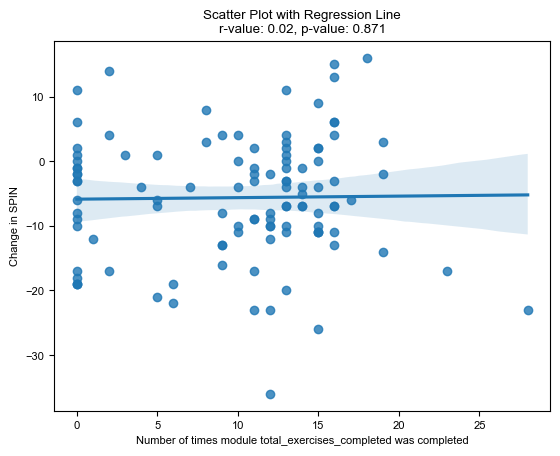

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Assuming you have a DataFrame 'df' with columns 'group', 'total_M0', 'total_M1', 'total_M2', 'total_M3', 'total_M4',
# 'M0A1', 'M0E1', 'M0E2', 'M0E3', 'M1E1', 'M1E2', 'M1E3', 'AC3P1a', 'M2E2a', 'M2E2b', 'M2E3', 'M2E4', 'M3E1', 'M3E2', 'M3E3', 'M4E1', 'M4E2', 'M4E3', 'M4E4'

# Filter rows where 'group' is equal to "Intervention"
intervention_adherence = df[df['group'] == "Intervention"]

# Columns to calculate average and SEM
columns_to_average = ['total_exercises_completed']

# Create a figure with three subplots: one for average adherence with SEM, one for completed percentages, and one for the difference between 'spintot_w0' and 'spintot_w2'
fig, ax1 = plt.subplots()

xvalues = intervention_adherence[columns_to_average].mean(axis=1)
yvalues = difference_values
data = pd.concat([xvalues, yvalues], axis=1)
data.dropna(inplace=True)

# Calculate the regression statistics
x_values = data.iloc[:, 0]
y_values = data.iloc[:, 1]
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

# Use sns.regplot to create the scatter plot with regression line
sns.regplot(x=x_values, y=y_values)
ax1.set_title(f'Scatter Plot with Regression Line\nr-value: {r_value:.2f}, p-value: {p_value:.3f}')

ax1.set_xlabel('Number of times module ' + columns_to_average[0] + ' was completed')
ax1.set_ylabel('Change in SPIN')


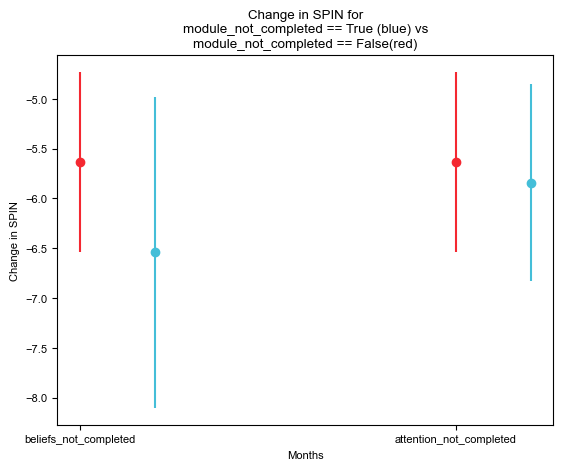

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Module completion

# Filter rows where 'group' is equal to "Intervention"
intervention_adherence = df[df['group'] == "Intervention"]

# Columns to calculate average and SEM
columns_to_average = ['beliefs_not_completed','attention_not_completed']

# Create a figure with three subplots: one for average adherence with SEM, one for completed percentages, and one for the difference between 'spintot_w0' and 'spintot_w2'
fig, ax = plt.subplots()

# Loop through columns_to_average
for i, column in enumerate(columns_to_average):
    # Calculate the mean of difference_values for users with intervention_adherence[column] > 0
    
    mean_difference_positive = difference_values[intervention_adherence.index][intervention_adherence[column] == True].mean()
    # Calculate the mean of difference_values for users with intervention_adherence[column] == 0
    mean_difference_negative = difference_values[intervention_adherence.index][intervention_adherence[column] == False].mean()

    # Calculate standard deviation of difference_values for users with intervention_adherence[column] > 0
    std_difference_positive = difference_values[intervention_adherence.index][intervention_adherence[column] > 0].sem()
    # Calculate standard deviation of difference_values for users with intervention_adherence[column] == 0
    mean_difference_negative = difference_values[intervention_adherence.index][intervention_adherence[column] == 0].sem()

    ax.errorbar(i, mean_difference_zero, yerr=std_difference_zero, marker='o', label=f'{column} == 0', color="#f42831", mec="#f42831")
    ax.errorbar(i +0.2, mean_difference_positive, yerr=std_difference_positive, marker='o', label=f'{column} > 0', color="#44bed8", mec="#44bed8")
    
    ax.set_xlabel('Months')
    ax.set_ylabel('Change in SPIN')
    ax.set_title(f'Change in SPIN for\nmodule_not_completed == True (blue) vs\nmodule_not_completed == False(red)')
    ax.set_xticks(range(0,len(columns_to_average))) # Set xticks to match index of intervention_adherence DataFrame
    ax.set_xticklabels(columns_to_average) # Set xtick labels to 'group' values with rotation

# Customize the appearance of the plots
